In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!mkdir COVID\ Dataset
!unzip /content/drive/MyDrive/covid19-pneumonia-normal-chest-xraypa-dataset.zip -d COVID\ Dataset

Archive:  /content/drive/MyDrive/covid19-pneumonia-normal-chest-xraypa-dataset.zip
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg  
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg  
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/0C7E78DA-FAFC-480D-88B6-1459C51481AF-1068x817.jpeg  
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6-1068x1086.jpeg  
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/134895D3-77B8-4546-B7E5-C7DABD600309-1068x911.jpeg  
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D-768x635.jpeg  
  inflating: COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/1F6343EE-AFEC-4B7D-97F5-62797EE18767-10

In [ ]:
import os

os.chdir('/content/COVID Dataset/')

path = '/content/COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'

In [ ]:
!ls

In [ ]:
import pandas as pd

df = pd.read_csv("metadata.csv")

df.head(10)

In [ ]:

import matplotlib.pyplot as plt

class_counts = df.iloc[:, 1].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
df.isna().sum()

In [ ]:
class_counts = df.iloc[:, 1].value_counts()
class_counts

In [ ]:
!ls

COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset	metadata.csv


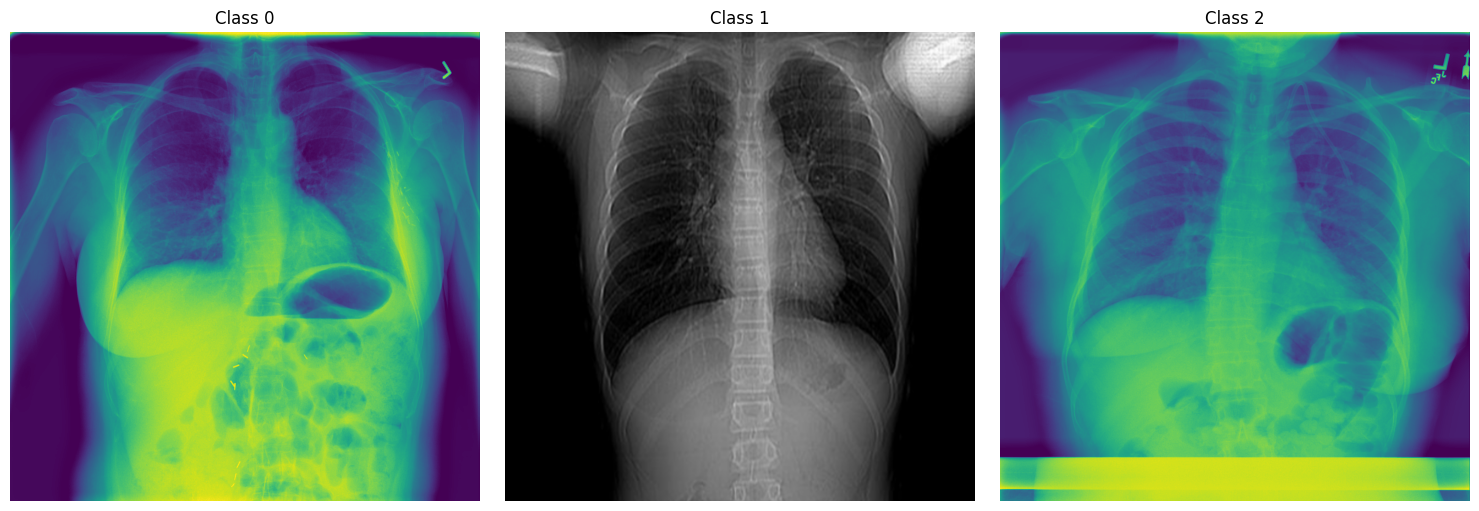

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

metadata = df

sample_images = metadata.groupby('class').first().reset_index()

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for idx, (index, row) in enumerate(sample_images.iterrows()):
    img_path = "COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/" + row['directory']

    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Class {row["class"]}')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()


In [ ]:
!pip install -q torchxrayvision torcheval grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 11.7 MB/s eta 0:00:00


In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)


In [ ]:
!ls

In [ ]:
import shutil

folder_path = '/content/COVID Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/test'

if os.path.exists(folder_path):
  shutil.rmtree(folder_path)
  print(f"Folder '{folder_path}' deleted successfully.")
else:
  print(f"Folder '{folder_path}' does not exist.")

In [ ]:
class_names = ['normal', 'pneumonia', 'covid']
root_dir    = 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
source_dirs = ['normal', 'pneumonia', 'covid']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('jpg') or x.lower().endswith('png') or x.lower().endswith('jpeg')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('jpg') or x.lower().endswith('png') or x.lower().endswith('jpeg')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'pneumonia', 'covid']

        for c in self.class_names:
            self.images[c] = get_images(c)

        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dirs = {
    'normal': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/normal',
    'pneumonia': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia',
    'covid': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

In [ ]:
test_dirs = {
    'normal': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/test/normal',
    'pneumonia': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/test/pneumonia',
    'covid': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

In [ ]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs  = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

show_preds()

In [ ]:
def train(epochs=1):
    print('Starting training..')

    # Lists to store the loss and accuracy for later plotting
    train_losses = []
    val_losses = []
    accuracies = []

    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train()  # Set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0
                resnet18.eval()  # Set model to eval phase

                for val_step, (val_images, val_labels) in enumerate(dl_test):
                    val_outputs = resnet18(val_images)
                    val_loss += loss_fn(val_outputs, val_labels).item()

                    _, preds = torch.max(val_outputs, 1)
                    accuracy += (preds == val_labels).sum().item()

                val_loss /= (val_step + 1)
                accuracy /= len(dl_test.dataset)  # Correct calculation of accuracy
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                val_losses.append(val_loss)
                accuracies.append(accuracy)

                show_preds()
                resnet18.train()

                if accuracy >= 0.97:
                    print('97%+ accuracy reached')
                    return train_losses, val_losses, accuracies

        train_loss /= (train_step + 1)
        train_losses.append(train_loss)  # Store the training loss

        print(f'Training Loss: {train_loss:.4f}')

    print('Training complete..')
    return train_losses, val_losses, accuracies

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1410, Accuracy: 0.9556


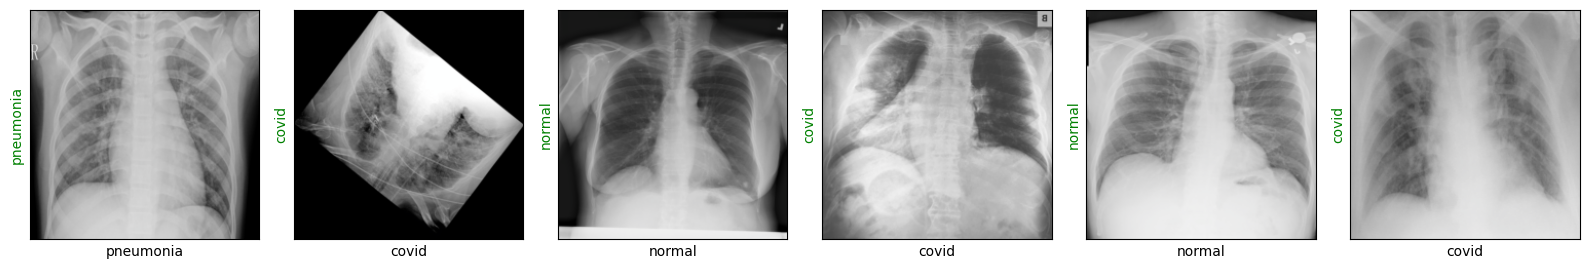

In [ ]:
train_losses, val_losses, accuracies = train(epochs=1)

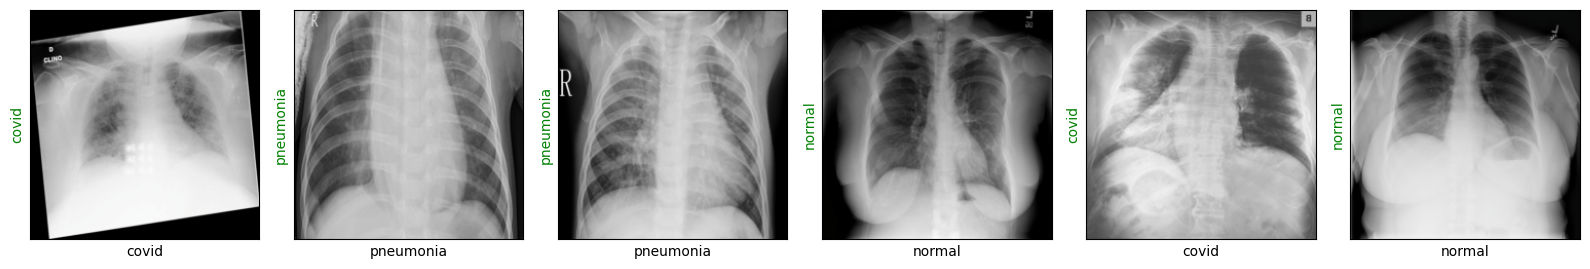

In [ ]:
show_preds()

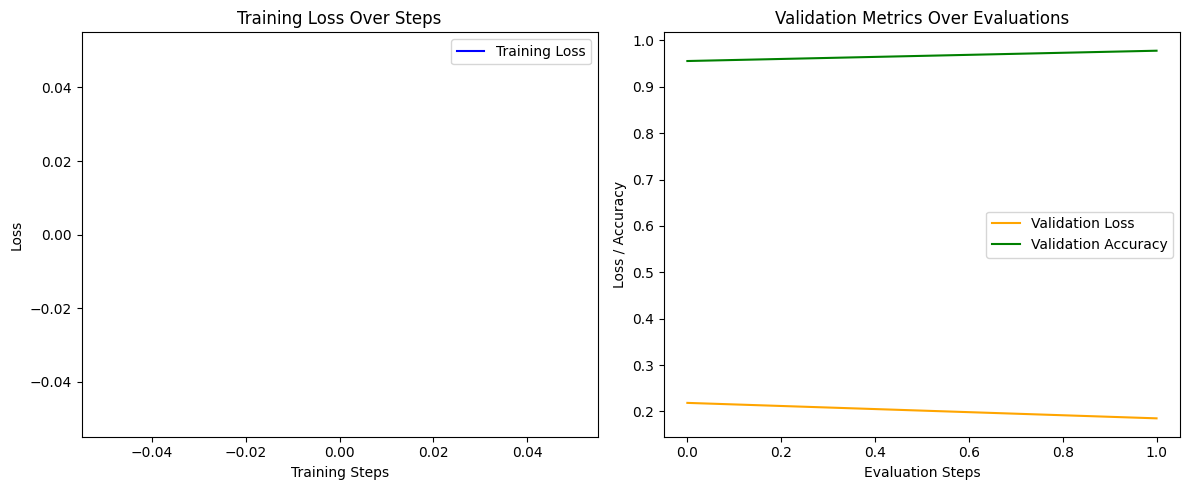

In [ ]:
def plot_results(train_losses, val_losses, accuracies):
    eval_steps = range(len(val_losses))  # Use validation losses for x-axis

    plt.figure(figsize=(12, 5))

    # Plotting training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss Over Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation loss and accuracy
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, val_losses, label='Validation Loss', color='orange')
    plt.plot(eval_steps, accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Metrics Over Evaluations')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss / Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(train_losses, val_losses, accuracies)

In [ ]:
torch.save(resnet18.state_dict(),'covid_model_resnet18.pth')

In [ ]:
!ls

COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset	covid_model_resnet18.pth  metadata.csv


In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load the base model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes (3 in this case)
num_classes = 3  # Change this to your actual number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the state dict
model.load_state_dict(torch.load('covid_model_resnet18.pth'))
model.eval()

<ipython-input-102-65dfd7d5d0d2>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('covid_model_resnet18.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 14.0 MB/s eta 0:00:00


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from PIL import Image
import torchvision
import torch.nn.functional as F
import cv2
import seaborn as sns
from torchmetrics import ConfusionMatrix

In [ ]:
test_pred_labels = []
test_true_labels = []
train_pred_labels = []
train_true_labels = []
ps_list = []
ps_list_train = []
running_correct = 0.0
running_total = 0.0
running_correct_train = 0.0
running_total_train = 0.0
accuracy_test=0.0
accuracy_train=0.0

def data_extraction(pred_label, true_label, ps_label, dataset, correct, total, accuracy):
    with torch.no_grad():
        for images, labels in dataset:
            output = model(images)  # No need for model.eval() here
            ps = F.softmax(output, dim=1)
            output = (torch.max(torch.exp(output), 1)[1]).numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            #ps = ps.data.cpu().numpy().squeeze()
            #ps_label.extend(np.max(ps))
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct/total
        return pred_label,true_label,ps_label,dataset,correct,total,accuracy

In [ ]:


one=data_extraction(test_pred_labels,test_true_labels,ps_list,dl_test,running_correct,running_total,accuracy_test)

target_test = torch.tensor(one[1])
preds_test = torch.tensor(one[0])
confmat = ConfusionMatrix(num_classes=3, task='multiclass')
mat_tensor = confmat(preds_test, target_test)
print(mat_tensor)

tensor([[68,  0,  0],
        [ 8, 51,  0],
        [ 0,  0, 53]])


In [ ]:
two=data_extraction(train_pred_labels,train_true_labels,ps_list_train,dl_train,running_correct_train,running_total_train,accuracy_train)

target_train = torch.tensor(two[1])
preds_train = torch.tensor(two[0])
confmat2 = ConfusionMatrix(num_classes=3, task="multiclass")
mat_tensor2 = confmat2(preds_train, target_train)

print(mat_tensor2)

tensor([[1458,    7,    1],
        [  51, 1419,    0],
        [   2,    2, 1485]])


In [ ]:
print("Total Correct Images: {}, Total Test Images: {}".format(int(one[4]), int(one[5])))
print("Test Accuracy: ", one[6])

Total Correct Images: 86, Total Test Images: 90
Test Accuracy:  0.9555555555555556


In [ ]:
print("Total Correct Images: {}, Total Train Images: {}".format(int(two[4]), int(two[5])))
print("Train Accuracy: ", two[6])

Total Correct Images: 4362, Total Train Images: 4425
Train Accuracy:  0.9857627118644068


In [ ]:
import sklearn.metrics as metrics
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(one[1], one[0],target_names=classes)))

print("Classification report for train set:\n%s\n"
      % (metrics.classification_report(two[1], two[0],target_names=classes)))

Classification report for test set:
              precision    recall  f1-score   support

      normal       0.89      1.00      0.94        68
   pneumonia       1.00      0.86      0.93        59
       covid       1.00      1.00      1.00        53

    accuracy                           0.96       180
   macro avg       0.96      0.95      0.96       180
weighted avg       0.96      0.96      0.96       180


Classification report for train set:
              precision    recall  f1-score   support

      normal       0.96      0.99      0.98      1466
   pneumonia       0.99      0.97      0.98      1470
       covid       1.00      1.00      1.00      1489

    accuracy                           0.99      4425
   macro avg       0.99      0.99      0.99      4425
weighted avg       0.99      0.99      0.99      4425


